**Import Necessary Libraries**

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

**Define Functions for Model and Data Preperation**

In [23]:
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        LSTM(units=50, return_sequences= False, kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(units=25, kernel_regularizer=l2(0.01)),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss=custom_weighted_loss)
    return model

In [24]:
def custom_weighted_loss(y_true, y_pred):
    weights = tf.range(1, tf.shape(y_true)[0] + 1, dtype=tf.float32)
    weights = tf.math.exp(weights / tf.reduce_max(weights))
    loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    return tf.reduce_mean(loss * weights)

In [25]:
def prepare_data(df, sequence_length=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i - sequence_length:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

**Load and Prepare the Data**

In [26]:
def load_stock_data(filepath):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    return df

df = load_stock_data('../data/nvidia_stock.csv')
X, y, scaler = prepare_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) 

**Callbacks for Training Stability**

In [27]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6 , verbose=1) 
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

**Train the LSTM model**

In [28]:
model = create_lstm_model(input_shape=(X_train.shape[1], 1))
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[reduce_lr, early_stop])

Epoch 1/50


c:\Users\athar\anaconda3\envs\data_science\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 0.6903 - val_loss: 0.0817 - learning_rate: 0.0010
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0485 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0043 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 3.5339e-04 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 6.0775e-05 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 4.4655e-05 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 4.3296e-05 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 4.2615e-05 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 5.0624e-05 - val_loss: 0.0017 - learning_

**Visualize Training History**

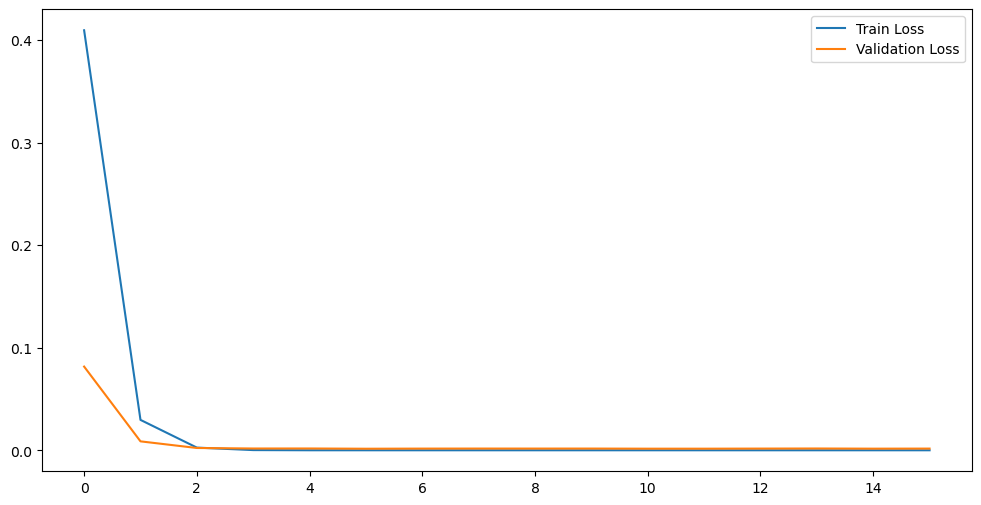

In [29]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

**Evaluate Model Performance**

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Mean Squared Error: 3090.798251764083


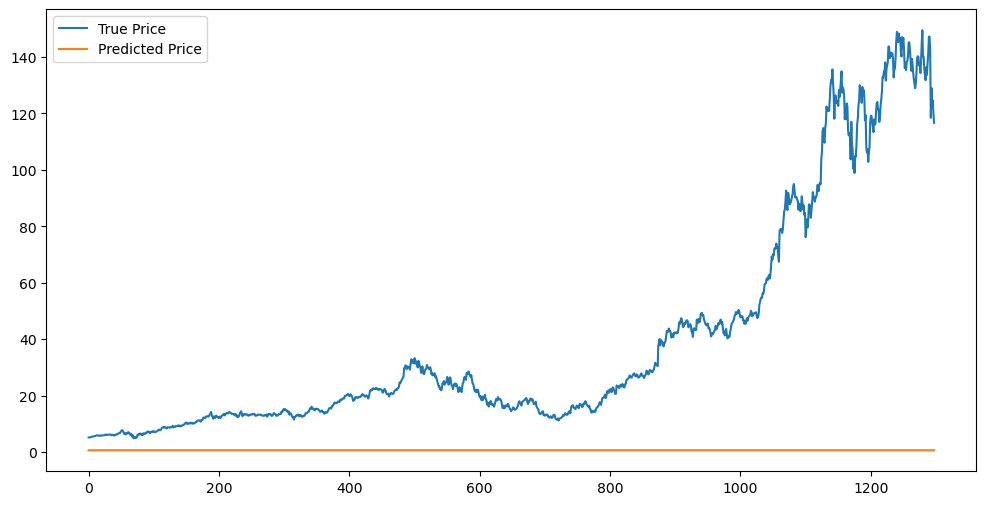

3090.798251764083

In [30]:
def evaluate_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = predictions.reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)

    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse}')

    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='True Price')
    plt.plot(predictions, label='Predicted Price')
    plt.legend()
    plt.show()

    return mse

evaluate_model(model, X_test, y_test, scaler)